<a href="https://colab.research.google.com/github/Lizzy-Mejia/Data_Science_FemHack_Challenge/blob/main/Classification_Requests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalación de librerías que seran necesarias para ciertos procesos.
!pip install --upgrade googletrans==4.0.0-rc1
!pip install translate
!pip install langdetect

In [2]:
# Procesado y tratamiento de los datos
import re
import numpy as np
import pandas as pd
import string
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from langdetect import detect
from googletrans import Translator
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Balanceo del dataset
from imblearn.over_sampling import SMOTEN

# División del dataset
from sklearn.model_selection import train_test_split

# Búsqueda de los mejores parámetros
from sklearn.model_selection import GridSearchCV

# Reducción de caraterísticas
from sklearn.decomposition import PCA

# Modelos utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métricas de evaluación
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# Otros
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Lectura del dataset de entrenamiento
data = pd.read_csv('train.csv')
# Visualización inicial del conjunto de datos
data

,train_idx,title,description,target,creator_name,creator_location,supporters,created_date,banner_image,full_content,victory_flag
0,0,Stop Iran Regime from Chairing U​.​N. Human Ri...,Rights Council 2023 Social Forum. This year's ...,['António Guterres'],UN Watch,"Geneva, Switzerland",80515,10 May 2023,https://assets.change.org/photos/2/ur/wj/vrUrW...,No Joke: The Islamic Republic of Iran has just...,0
1,1,Save Children In Poverty In Syria,Children in Syria are facing extreme poverty. ...,['UNICEF'],Maialen Alawam,"Watertown, MA, United States",23871,25 Jun 2020,https:https://static.change.org/images/default...,Children in Syria are facing extreme poverty. ...,0
2,2,Save Duke Ellington School Of The Arts,NaN,NaN,It’s Me Tivoni,United States,4051,"Nov. 20, 2022",https://assets.change.org/photos/8/ab/hv/DZaBH...,Save Duke Ellington School Of The ArtsTivoni H...,0
3,3,Mobile operators are creating inequality,"In India, after Reliance Jio (a 4G only mobile...","['Telecom Regulatory Authority of India', 'CEL...",Swastik Raj Chauhan,"Ghaziabad, India",350,"Oct 15, 2017",https://assets.change.org/photos/7/by/in/Kzbyi...,"In India, after Reliance Jio (a 4G only mobile...",0
4,4,Grant Military Burial Honors to Women WWII Pilots,"During World War II, a brave group of women jo...",['U.S. Senate'],Tiffany Miller @tiffbmiller,"Walnut Creek, CA, United States",176092,2 Dec 2015,https://assets.change.org/photos/3/lh/jc/TmLhJ...,"During World War II, a brave group of women jo...",1
...,...,...,...,...,...,...,...,...,...,...,...
1960,1960,Justice pour Fortune,Une étudiante togolaise assassinée en France,['Pétition adressée à au Gouvernement Togolais...,Yao KLEGBAZA,Ghana,15341,Date de création 10 déc. 2022,https://assets.change.org/photos/3/im/dw/aLImD...,Une étudiante togolaise assassinée en France,1
1961,1961,100% Clean Renewable Energy by 2030.,"switch to 100% clean renewable energy by 2030,...","['The World', 'Joseph R. Biden', 'Boris Johnso...",Jack B.,"New Mexico, United States",4036,8 Aug 2021,https://assets.change.org/photos/2/nw/hz/dpNwH...,We have less than 7 years until the effects of...,0
1962,1962,Create a Fair and Compassionate UK Immigration...,treated?\nThis petition challenges the U.K. go...,"['Sajid Javid', 'Caroline Nokes', 'Diane Abbott']",D K Thomas,"Salisbury, ENG, United Kingdom",6393,"Jun 4, 2018",https://assets.change.org/photos/6/eo/ir/yUeOi...,"If your dream was to live in another country, ...",0
1963,1963,Approve my Social Security Disability,disability have been denied even though my med...,['Richard Burr'],Cel Layne,"Lynchburg, VA, United States",71938,20 Jan 2016,https://assets.change.org/photos/0/qa/ut/Fnqau...,I WANT TO PERSONALLY THANK EVERY ONE OF YOU FO...,1


In [4]:
# Eliminaremos la siguiente columna ya que no es relevante para nuestra variable objetivo
df1 = data.drop(['train_idx'], axis=1)

In [5]:
# Lectura del dataset de pruebas
data_prueba = pd.read_csv('test.csv')
# Visualización inicial del conjunto de datos
data_prueba

,test_idx,title,description,target,creator_name,creator_location,supporters,created_date,banner_image,full_content
0,0,Get my case heard for neglect,son in another empty labor and delivery room l...,"['Virginia Governor', 'St francis hospital', '...",tyra reyes,"Richmond, VA, United States",149447,"Oct. 26, 2017",https://assets.change.org/photos/3/sq/fl/Klsqf...,On 3/12/17 I was at home talking to my sister ...
1,1,JUSTICE POUR JOE ET DAX: pour une peine exempl...,"Le 13 Février 2018, 3 chiens étaient déposés c...","['Pétition adressée à Nicole Belloubet', 'Cyri...",Daniel MADEIRA,France,53919,Date de création 10 mai 2019,https://assets.change.org/photos/7/xj/js/ONxJJ...,"Le 13 Février 2018, 3 chiens étaient déposés c..."
2,2,Mandatory Course in Mental Health for Highschool,"In any given year, 1 in 5 people in Canada wil...","['The Minister Of Education', 'Halton Catholic...",Jayme Robinson,"Oakville, Canada",30635,"Jun 11, 2018",https://assets.change.org/photos/8/px/bz/oupXB...,"In any given year, 1 in 5 people in Canada wil..."
3,3,Stop coronavirus - call for permanent ban on c...,Français\nрусский \nPlease take action to supp...,"[""National People's Congress (NPC)"", 'WHO', 'O...",ACTAsia Education,United Kingdom,48004,20 Feb 2020,https://assets.change.org/photos/9/fc/zm/cZFCZ...,Français\n\nрусский\n\nPlease take action to s...
4,4,Chiedere alle Nazioni Unite che il 2018 sia l'...,"population?- induced as they are by violence, ...",['Petizione diretta a Assemblea Generale Nazio...,Cristiana Fiamingo,"Università degli Studi di Milano, Italia",436,Data di lancio 27 lug 2017,https://assets.change.org/photos/3/fd/wb/Cjfdw...,[ITA] Se osservate la lista delle annate inter...
...,...,...,...,...,...,...,...,...,...,...
487,487,Restore student privacy,. Lightspeed and GoGaurdian are gross violatio...,['Princeton administratio n'],william alena,United States,123,"Apr. 15, 2021",https://assets.change.org/photos/5/ru/pe/RqRup...,Protecting students from self harm is incredib...
488,488,Petition the International Maritime Organizati...,public support in advance of this meeting will...,['International Maritime Organization (IMO)'],Environmental Investigation Agency,"London, ENG, United Kingdom",89876,10 Nov 2021,https://assets.change.org/photos/4/cf/gq/EsCFG...,"In May 2021, the MV X-Press Pearl spilt 1,680 ..."
489,489,Keep the Arts in Our Schools,Talbot County Public Schools have decided to c...,['Talbot County Public Schools'],Brett Hutchinson,"Easton, MD, United States",4565,"Mar. 29, 2019",https://assets.change.org/photos/5/cl/yx/iPcLy...,Talbot County Public Schools have decided to c...
490,490,Save Adelaide's arts community! Save Flinders ...,Creative Arts (Drama) aka The Drama Centre. Fo...,['artists'],Ren Williams,Australia,8616,"Dec 10, 2020",https://assets.change.org/photos/4/xt/qc/aaXtQ...,Flinders University has made the devastating d...


In [6]:
# Eliminaremos la siguiente columna ya que no es relevante para nuestra variable objetivo
df2 = data_prueba.drop(['test_idx'], axis=1)

In [7]:
# Uniremos el dataset de entrenameinto y pruebas para poder aplicarles los mismo procesos de transformación
data_all = pd.concat([df1, df2])
# Reseteamos el index de la filas
data_all = data_all.reset_index(drop=True)
# Visualizamos los resultados
data_all

,title,description,target,creator_name,creator_location,supporters,created_date,banner_image,full_content,victory_flag
0,Stop Iran Regime from Chairing U​.​N. Human Ri...,Rights Council 2023 Social Forum. This year's ...,['António Guterres'],UN Watch,"Geneva, Switzerland",80515,10 May 2023,https://assets.change.org/photos/2/ur/wj/vrUrW...,No Joke: The Islamic Republic of Iran has just...,0.0
1,Save Children In Poverty In Syria,Children in Syria are facing extreme poverty. ...,['UNICEF'],Maialen Alawam,"Watertown, MA, United States",23871,25 Jun 2020,https:https://static.change.org/images/default...,Children in Syria are facing extreme poverty. ...,0.0
2,Save Duke Ellington School Of The Arts,NaN,NaN,It’s Me Tivoni,United States,4051,"Nov. 20, 2022",https://assets.change.org/photos/8/ab/hv/DZaBH...,Save Duke Ellington School Of The ArtsTivoni H...,0.0
3,Mobile operators are creating inequality,"In India, after Reliance Jio (a 4G only mobile...","['Telecom Regulatory Authority of India', 'CEL...",Swastik Raj Chauhan,"Ghaziabad, India",350,"Oct 15, 2017",https://assets.change.org/photos/7/by/in/Kzbyi...,"In India, after Reliance Jio (a 4G only mobile...",0.0
4,Grant Military Burial Honors to Women WWII Pilots,"During World War II, a brave group of women jo...",['U.S. Senate'],Tiffany Miller @tiffbmiller,"Walnut Creek, CA, United States",176092,2 Dec 2015,https://assets.change.org/photos/3/lh/jc/TmLhJ...,"During World War II, a brave group of women jo...",1.0
...,...,...,...,...,...,...,...,...,...,...
2452,Restore student privacy,. Lightspeed and GoGaurdian are gross violatio...,['Princeton administratio n'],william alena,United States,123,"Apr. 15, 2021",https://assets.change.org/photos/5/ru/pe/RqRup...,Protecting students from self harm is incredib...,NaN
2453,Petition the International Maritime Organizati...,public support in advance of this meeting will...,['International Maritime Organization (IMO)'],Environmental Investigation Agency,"London, ENG, United Kingdom",89876,10 Nov 2021,https://assets.change.org/photos/4/cf/gq/EsCFG...,"In May 2021, the MV X-Press Pearl spilt 1,680 ...",NaN
2454,Keep the Arts in Our Schools,Talbot County Public Schools have decided to c...,['Talbot County Public Schools'],Brett Hutchinson,"Easton, MD, United States",4565,"Mar. 29, 2019",https://assets.change.org/photos/5/cl/yx/iPcLy...,Talbot County Public Schools have decided to c...,NaN
2455,Save Adelaide's arts community! Save Flinders ...,Creative Arts (Drama) aka The Drama Centre. Fo...,['artists'],Ren Williams,Australia,8616,"Dec 10, 2020",https://assets.change.org/photos/4/xt/qc/aaXtQ...,Flinders University has made the devastating d...,NaN


In [8]:
# Verificamos cuales son las variables que poseen mas correlación con respecto a la variable de salida
data_all.corr()['victory_flag'].sort_values()

supporters      0.046517
victory_flag    1.000000
Name: victory_flag, dtype: float64

In [9]:
# Eliminación de datos que son irrelevantes y que podrían afectar el resultado.
data_new = data_all.drop(['banner_image','target','creator_name','description','creator_location','created_date','full_content','supporters'], axis=1)

In [10]:
# Validación de la cantidad de ejemplos que posee el dataset segun la variable de salida.
data_new["victory_flag"].value_counts()

0.0    1680
1.0     285
Name: victory_flag, dtype: int64

In [11]:
# Número de datos ausentes por variable
print(data_new.isnull().sum())

title             0
victory_flag    492
dtype: int64


In [12]:
# Pasamos todos los registros de la columna "title" a letras minúsculas
data_new['title'] = data_new['title'].str.lower()

In [13]:
# Removemos signos de puntuación y caracteres especiales de los registros de la columna "title"
data_new['title'] = data_new['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


In [14]:
# Generamos una copia del dataset
df_en = data_new.copy()

In [15]:
# Función de detección de lenguaje
df = df_en
# Función para detectar el idioma de un texto
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang
# Aplicar la detección de idioma a la columna 'text_column'
df['language'] = df['title'].apply(detect_language)
# Visualizamos los resultados
print(df["language"])

0       en
1       en
2       en
3       en
4       en
        ..
2452    ro
2453    en
2454    en
2455    en
2456    en
Name: language, Length: 2457, dtype: object


In [16]:
# El idioma al cual se estandarizara todos los registros sera inglés
# Utilizando la columna creada en la función anterior separaremos todos los registros con idioma diferente al inglés
data_traduct = df[(df['language'] != 'en')]
# Reseteamos el index de la filas
data_traduct = data_traduct.reset_index(drop=True)
# Visualizamos los datos localizados
data_traduct

,title,victory_flag,language
0,indigenous emoji au,0.0,lt
1,manifesto da esperança por dignidade e respei...,0.0,pt
2,no al reconocimiento de doctor honoris causa e...,0.0,es
3,insecticides tueurs dabeilles pas de dérogation,0.0,fr
4,our privacy la nostra privacy,0.0,fr
...,...,...,...
610,justice pour mathis jouanneau justice for mathis,NaN,fr
611,poverty,NaN,sk
612,alessandro barbero x joe rogan barbero ospite ...,NaN,pt
613,ucf support racial justice,NaN,ro


In [17]:
# Crear un objeto traductor
translator = Translator()
# Trasladamos los registros que seran traducidos
data_traduct['title'] = data_traduct['title'].apply(lambda x: translator.translate(x, dest='en').text)
# Visualizamos los resultados
data_traduct

,title,victory_flag,language
0,indigenous emoji au,0.0,lt
1,Manifesto of hope for dignity and respect for ...,0.0,pt
2,No to the recognition of Doctor Honoris Causa ...,0.0,es
3,Insecticides killers Dabeilles no derogation,0.0,fr
4,Our privacy our privacy,0.0,fr
...,...,...,...
610,Justice for Mathis Jouanneau Justice for Mathis,NaN,fr
611,poverty,NaN,sk
612,Alessandro Barbero x Joe Rogan Barbero guest a...,NaN,pt
613,ucf support racial justice,NaN,ro


In [18]:
# Como se puede observar en los resultados de la traducción anterior, hay algunos regsitros que obtuvieron letras mayusculas
# Pasamos todos los registros de la columna "title" a letras minúsculas
data_traduct['title'] = data_traduct['title'].str.lower()

In [19]:
# Separamos todos los registros en ingles para poder unirlos al nuevo dataset traducido
data_clean = df[df['language'] == 'en']
# Reseteamos el index de la filas
data_clean = data_clean.reset_index(drop=True)
# Visualizamos los resultados
data_clean

,title,victory_flag,language
0,stop iran regime from chairing un human rights...,0.0,en
1,save children in poverty in syria,0.0,en
2,save duke ellington school of the arts,0.0,en
3,mobile operators are creating inequality,0.0,en
4,grant military burial honors to women wwii pilots,1.0,en
...,...,...,...
1837,call for emergency medical care for children s...,NaN,en
1838,petition the international maritime organizati...,NaN,en
1839,keep the arts in our schools,NaN,en
1840,save adelaides arts community save flinders drama,NaN,en


In [20]:
# Unimos el dataset con los datos en inglés y el nuevo dataset traducido
data_all2 = pd.concat([data_traduct, data_clean])
# Reseteamos el index de la filas
data_all2 = data_all2.reset_index(drop=True)
# Visualizamos los resultados
data_all2

,title,victory_flag,language
0,indigenous emoji au,0.0,lt
1,manifesto of hope for dignity and respect for ...,0.0,pt
2,no to the recognition of doctor honoris causa ...,0.0,es
3,insecticides killers dabeilles no derogation,0.0,fr
4,our privacy our privacy,0.0,fr
...,...,...,...
2452,call for emergency medical care for children s...,NaN,en
2453,petition the international maritime organizati...,NaN,en
2454,keep the arts in our schools,NaN,en
2455,save adelaides arts community save flinders drama,NaN,en


In [21]:
# Separamos los datos de nuestro dataset de pruebas
null_rows = data_all2[data_all2.isnull().any(axis=1)]
# Reseteamos el index de la filas
null_rows = null_rows.reset_index(drop=True)
# Visualizamos los resultados
null_rows

,title,victory_flag,language
0,justice for joe and dax for an exemplary sentence,NaN,fr
1,ask the united nations that 2018 is the intern...,NaN,it
2,save patients rights,NaN,fr
3,at cp we learn french,NaN,fr
4,let's save the tire school in palestine thetyr...,NaN,it
...,...,...,...
487,call for emergency medical care for children s...,NaN,en
488,petition the international maritime organizati...,NaN,en
489,keep the arts in our schools,NaN,en
490,save adelaides arts community save flinders drama,NaN,en


In [22]:
# Eliminamos los datos de nuestros dataset de pruebas
# Para poder balancear nuestro dataset de entrenamiento
data_clean2 = data_all2.dropna()
# Reseteamos el index de la filas
data_clean2 = data_clean2.reset_index(drop=True)
# Visualizamos los resultados
data_clean2

,title,victory_flag,language
0,indigenous emoji au,0.0,lt
1,manifesto of hope for dignity and respect for ...,0.0,pt
2,no to the recognition of doctor honoris causa ...,0.0,es
3,insecticides killers dabeilles no derogation,0.0,fr
4,our privacy our privacy,0.0,fr
...,...,...,...
1960,gbv violation of womens rights to be prioriti...,0.0,en
1961,100 clean renewable energy by 2030,0.0,en
1962,create a fair and compassionate uk immigration...,0.0,en
1963,approve my social security disability,1.0,en


## Balanceo del dataset

In [23]:
# Conjunto de datos de entramiento
# Separamos la variable de salida del resto de datos
X_df = data_clean2.drop("victory_flag", axis=1)
y_df = data_clean2["victory_flag"].copy()

In [24]:
# Inicializamos el método de sobremuestreo
sampler = SMOTEN(random_state=0)
# Le pasamos el dataset
X_smoten, y_smoten = sampler.fit_resample(X_df, y_df)
# Hacemos un nuevo recuento para validar la cantidad de datos por cada clase
no_smoten = y_smoten.sum()
si_smoten = y_smoten.shape[0]- no_smoten
print('Personas que si firmaron:', si_smoten ,'Personas que no firmaron:', no_smoten)
# Visualizamos el dataset equilibrado para ambos casos
X_smoten

Personas que si firmaron: 1680.0 Personas que no firmaron: 1680.0


,title,language
0,indigenous emoji au,lt
1,manifesto of hope for dignity and respect for ...,pt
2,no to the recognition of doctor honoris causa ...,es
3,insecticides killers dabeilles no derogation,fr
4,our privacy our privacy,fr
...,...,...
3355,congress extend lifesaving legislation for int...,en
3356,congress extend lifesaving legislation for int...,en
3357,congress extend lifesaving legislation for int...,en
3358,congress extend lifesaving legislation for int...,en


In [25]:
# Unimos nuevamente la variable de salida al dataset para poder realizar la división de los datos
data_clean3= pd.concat([X_smoten, y_smoten], axis=1,sort=True)
# Visualizamos los cambios aplicados
data_clean3

,title,language,victory_flag
0,indigenous emoji au,lt,0.0
1,manifesto of hope for dignity and respect for ...,pt,0.0
2,no to the recognition of doctor honoris causa ...,es,0.0
3,insecticides killers dabeilles no derogation,fr,0.0
4,our privacy our privacy,fr,0.0
...,...,...,...
3355,congress extend lifesaving legislation for int...,en,1.0
3356,congress extend lifesaving legislation for int...,en,1.0
3357,congress extend lifesaving legislation for int...,en,1.0
3358,congress extend lifesaving legislation for int...,en,1.0


In [26]:
# Unimos nuevamente el dataset de entrenameinto y pruebas
data_all3 = pd.concat([data_clean3,null_rows])
# Reseteamos el index de la filas
data_all3 = data_all3.reset_index(drop=True)
# Visualizamos los resultados
data_all3

,title,language,victory_flag
0,indigenous emoji au,lt,0.0
1,manifesto of hope for dignity and respect for ...,pt,0.0
2,no to the recognition of doctor honoris causa ...,es,0.0
3,insecticides killers dabeilles no derogation,fr,0.0
4,our privacy our privacy,fr,0.0
...,...,...,...
3847,call for emergency medical care for children s...,en,NaN
3848,petition the international maritime organizati...,en,NaN
3849,keep the arts in our schools,en,NaN
3850,save adelaides arts community save flinders drama,en,NaN


In [27]:
# Vamos a reemplazar los valores vacios en la columna 'victory_flag'
# Que corresponden a los registros del dataset de test
# Ya que la siguiente función que necesitamos aplicarle a los datos
# Asiganara 0 a esos campos vacios y necesitamos diferecianlos
# Para la división final de los datos
data_all3['victory_flag'] = data_all3['victory_flag'].fillna(3)
# Visualizamos los cambios aplicados
data_all3['victory_flag'].value_counts()

0.0    1680
1.0    1680
3.0     492
Name: victory_flag, dtype: int64

In [28]:
# Definimos un pipeline para limpiar todos los campos de la columna 'title'
# El pipeline realizamos lo siguiente: (1) eliminar signos de putuación, (2) eliminar las stopwords
def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

In [29]:
# Probamos la función que anterior
df_prueba = data_all3['title'].apply(message_cleaning)
# visualizamos los resultados
print(df_prueba[2])

['recognition', 'doctor', 'honoris', 'causa', 'economics', 'iván', 'duque', 'south', 'korea']


In [30]:
# Aplicamos la función anterior a nuestro dataset
vectorizer = CountVectorizer(analyzer=message_cleaning)
# Realizamos la transformación para la columna seleccionada
reviews_countvectorizer = vectorizer.fit_transform(data_all3['title'])
# Extraemos los nombres de las claves creadas
feature_names = list(vectorizer.vocabulary_.keys())
print(feature_names)

['indigenous', 'emoji', 'au', 'manifesto', 'hope', 'dignity', 'respect', 'lgbtqiap', 'population', 'recognition', 'doctor', 'honoris', 'causa', 'economics', 'iván', 'duque', 'south', 'korea', 'insecticides', 'killers', 'dabeilles', 'derogation', 'privacy', 'exploitation', 'animals', 'imperial', 'royal', 'circus', 'new', 'normality', 'uma', 'nova', 'seek', 'rules', 'prevent', 'discrimination', 'university', 'dismissal', 'universities', 'say', 'class', 'try', 'loot', 'something', 'blacks', 'rampant', 'culture', 'day', 'stop', 'gender', 'apartheid', 'muslim', 'students', 'karnataka', 'colleges', 'salve', 'katy', 'keene', 'sauver', 'pen', 'truth', 'voice', 'congolese', 'people', 'defund', 'austin', 'police', 'department', 'provide', 'transport', 'facilities', 'jeeneet', 'equality', 'time', 'drag', 'tale', 'eurospin', 'publish', 'commitment', 'chicked', 'chickens', 'eggs', 'reform', 'transzorg', 'amsterdam', 'umc', 'animal', 'cruelty', 'ban', 'plastic', 'bags', 'immigration', 'visa', 'deser

In [31]:
# Convertimos los resultados a un dataframe
data_traduct = pd.DataFrame(reviews_countvectorizer.toarray())
# Eliminamos la columna del dataset original para poder agregar la nueva columa con cambios
data_all3.drop(['title'], axis = 1, inplace = True)
# Concatenamos los datos tranformados con la variable de salida
data_clean4 = pd.concat([data_all3, data_traduct], axis = 1)
# Visualizamos los cambios aplicados
data_clean4

,language,victory_flag,0,1,2,3,4,5,6,7,...,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103
0,lt,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,pt,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,es,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,fr,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,fr,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,en,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3848,en,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3849,en,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3850,en,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# La columna 'language' ya no será util para nuestros siguientes procesos
# Por lo que se se procedera con su eliminación
data_clean4 = data_clean4.drop(['language'], axis=1)
# Nos aseguramos que el nombre de las nuevas columnas tenga el tipo de dato correcto
data_clean4.columns = data_clean4.columns.astype(str)
# Visualizamos los cambios aplicados
data_clean4

,victory_flag,0,1,2,3,4,5,6,7,8,...,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3848,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3849,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3850,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Todas la tranformaciones para nuestros datos estan completas
# Por lo que procederemos a separar nuevamente nuestros datasets
# Extraemos nuestros datos de test
test2 = data_clean4[data_clean4['victory_flag'] == 3]
# Reseteamos el index de la filas
test2 = test2.reset_index(drop=True)
# La columna 'victory_flag' ya no será util para nuestros siguientes procesos
# Por lo que se se procedera con su eliminación
test2 = test2.drop(['victory_flag'], axis=1)
# Visualizamos los resultados
test2

,0,1,2,3,4,5,6,7,8,9,...,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Extraemos nuestros datos de entrenamiento
train2 = data_clean4[data_clean4['victory_flag'] != 3]
# Visualizamos los resultados
train2

,victory_flag,0,1,2,3,4,5,6,7,8,...,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3356,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3357,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3358,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## División del conjunto de datos

In [35]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [36]:
# Division del conjunto de datos en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(train2, stratify='victory_flag')

In [37]:
#Verificamos las particiones realizadas
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 2016
Longitud del Validation Set: 672
Longitud del Test Set: 672


In [38]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("victory_flag", axis=1)
y_train = train_set["victory_flag"].copy()

In [39]:
# Conjunto de datos de pruebas
X_val = val_set.drop("victory_flag", axis=1)
y_val = val_set["victory_flag"].copy()

In [40]:
# Conjunto de datos de test
X_test = test_set.drop("victory_flag", axis=1)
y_test = test_set["victory_flag"].copy()

## Selección de los mejores modelos

In [41]:
# Pruebas de con diferentes modelos
models = []
models.append(['Logistic Regreesion', LogisticRegression()])
models.append(['SVM', SVC()])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier()])
models.append(['Random Forest', RandomForestClassifier()])
models.append(['Ada Boost', AdaBoostClassifier()])

# Evaluación de los diferentes modelos
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kFold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kFold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()*100.0:,.2f}% ({cv_results.std()*100.0:,.2f}%)")

Logistic Regreesion: 90.52% (2.96%)
SVM: 90.47% (2.58%)
KNeighbors: 90.28% (2.40%)
GaussianNB: 78.07% (2.06%)
BernoulliNB: 89.73% (2.56%)
Decision Tree: 88.69% (2.56%)
Random Forest: 90.72% (2.69%)
Ada Boost: 89.78% (2.64%)


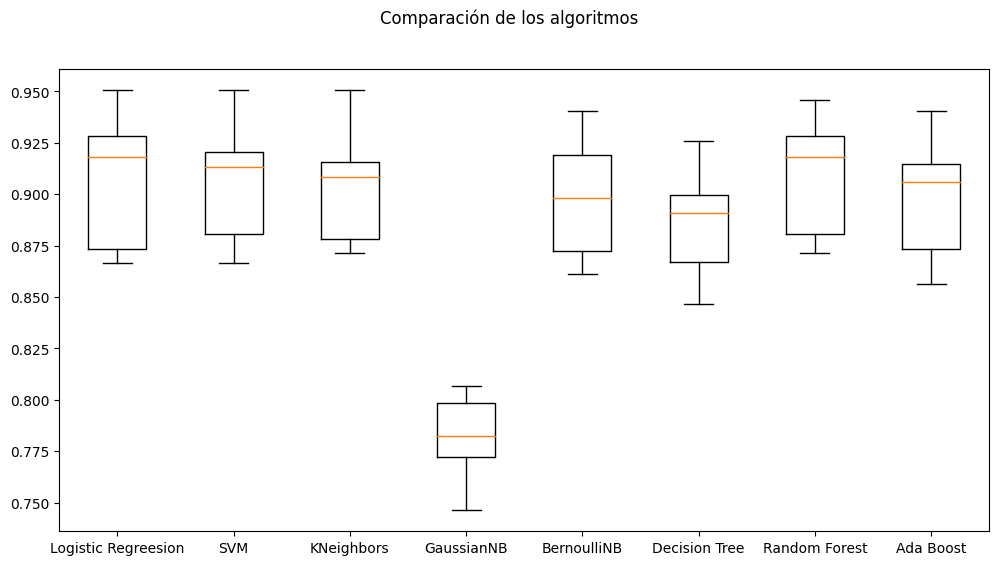

In [42]:
# Gráfica de caja para verificar el rendimiento de los diferentes modelos probados
fig = plt.figure(figsize =(12,6))
fig.suptitle('Comparación de los algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Hiperparametrización de los mejores modelos

In [43]:
# Búsqueda de los mejores parámetros para "Bosques aleatorios"
parameters = {"max_depth": [1, 2, 3, None],
              "max_features": [1, 2, 3, "sqrt", "log2"],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy", "log_loss"]
              }

model_RFC = RandomForestClassifier()
kFold = KFold(n_splits=10, random_state=7, shuffle=True)

grid = GridSearchCV(estimator=model_RFC, param_grid=parameters, cv=kFold, return_train_score=True)
grid_result= grid.fit(X_train, y_train)

# mejores parámetros
grid_result.best_params_

{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1}

## Prueba del modelo final

In [44]:
# Entrenamiento y prueba del modelo final
# Inicializamos el modelo y aplicamos reducción de dimensionalidad con PCA
steps = [('pca', PCA(n_components=25)), ('RFC', RandomForestClassifier(**grid_result.best_params_))]
modelo_final = Pipeline(steps=steps)
# Ajuste del modelo
modelo_final.fit(X_train,y_train)

# Realizamos una nueva predición con los datos de prueba
y_pred = modelo_final.predict(X_val)

# Evaluamos el rendimiento del modelo con los datos de prueba
accuracy_score(y_val, y_pred)

0.9375

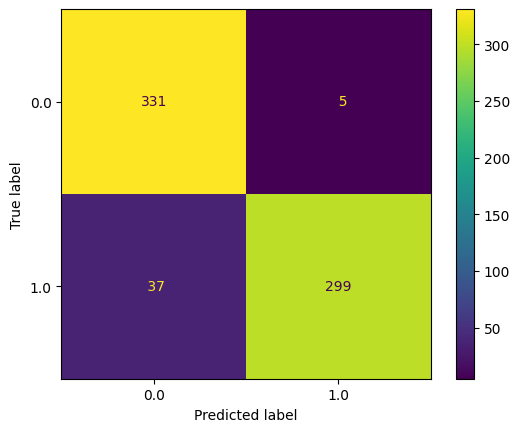

In [45]:
# Resultados de la matriz de confusión con los datos de prueba
ConfusionMatrixDisplay.from_estimator(modelo_final, X_val, y_val, values_format='3g')

In [46]:
# Reporte de los resultados que se obtuvieron con los datos de prueba
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       336
         1.0       0.98      0.89      0.93       336

    accuracy                           0.94       672
   macro avg       0.94      0.94      0.94       672
weighted avg       0.94      0.94      0.94       672



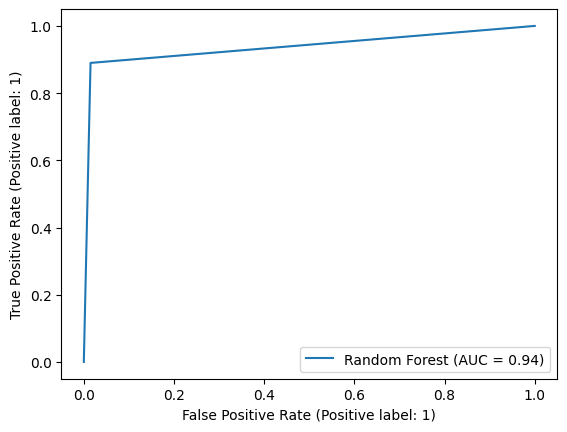

In [47]:
# Curva ROC para los datos de prueba
RocCurveDisplay.from_predictions(y_val, y_pred, name="Random Forest")
plt.show()

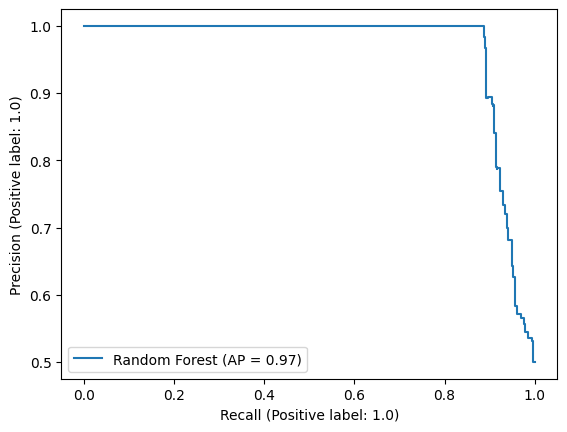

In [48]:
# Curva PR para los datos de prueba
PrecisionRecallDisplay.from_estimator(modelo_final, X_val, y_val, name="Random Forest")

In [49]:
# Realizamos una nueva predición con los datos de test
y_pred2 = modelo_final.predict(X_test)

# Evaluamos el rendimiento del modelo con los datos de test
accuracy_score(y_test, y_pred2)

0.9226190476190477

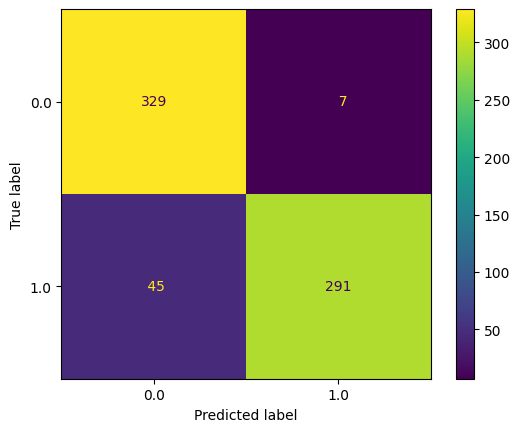

In [50]:
# Resultados de la matriz de confusión con los datos de test
ConfusionMatrixDisplay.from_estimator(modelo_final, X_test, y_test, values_format='3g')

In [51]:
# Reporte de los resultados que se obtuvieron con los datos de test
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       336
         1.0       0.98      0.87      0.92       336

    accuracy                           0.92       672
   macro avg       0.93      0.92      0.92       672
weighted avg       0.93      0.92      0.92       672



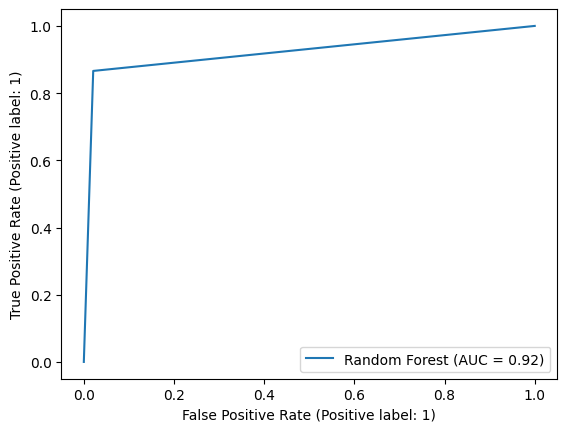

In [52]:
# Curva ROC para los datos de test
RocCurveDisplay.from_predictions(y_test, y_pred2, name="Random Forest")
plt.show()

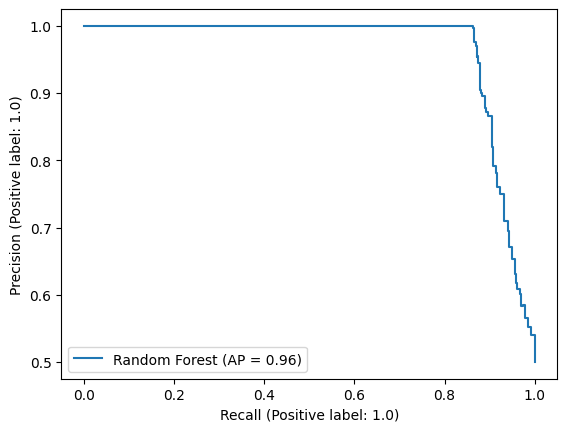

In [53]:
# Curva PR para los datos de test
PrecisionRecallDisplay.from_estimator(modelo_final, X_test, y_test, name="Random Forest")

## Prueba del modelo con los datos de Test

In [54]:
# Realizamos una nueva predición con los datos de prueba
y_pred_prueba = modelo_final.predict(test2)
# Visualizamos los resultados
y_pred_prueba

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.

In [55]:
# Guardamos los resultados de las predicciones
pd.DataFrame(y_pred_prueba, columns=['target'], index=test2.index).to_json("predictions.json", orient="columns", index=True)